In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#importing the necessary packages 

import numpy as np
import pandas as pd
import os 
from PIL import Image
import matplotlib.pyplot as plt

import random
import tensorflow as tf
from keras.models import Sequential
from keras.layers import MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

print("GPUs detected:", tf.config.list_physical_devices('GPU'))

GPUs detected: []


In [3]:
# setting up the data paths

base_dir = '' # base directory
images_dir = os.path.join(base_dir,'C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/imgs/')                   # images directory
test_dir = os.path.join(base_dir,'C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/imgs/test/')                # test directory
train_dir = os.path.join(base_dir,'C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/imgs/train/')              # train directory

driver_imgs_list = pd.read_csv(os.path.join(base_dir,'C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/driver_imgs_list.csv'))  # images list csv 
sample_sub = pd.read_csv(os.path.join(base_dir,'C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/sample_submission.csv'))  

In [4]:
driver_imgs_list.head()

,subject,classname,img
0,p012,c0,img_10206.jpg
1,p012,c0,img_27079.jpg
2,p012,c0,img_50749.jpg
3,p012,c0,img_97089.jpg
4,p012,c0,img_37741.jpg


In [5]:
classes = driver_imgs_list['classname'].unique()
classes

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

In [6]:
class_def = {
    'c0': 'Safe driving', 
    'c1': 'Operating the radio',
    'c2': 'Drinking', 
    'c3': 'Reaching behind', 
    'c4': 'Hair and makeup', 
    'c5': 'Talking to passenger',
    'c6': 'General Distracted',
    'c7': 'Sleepy',
    'c8': 'Yawn'
}


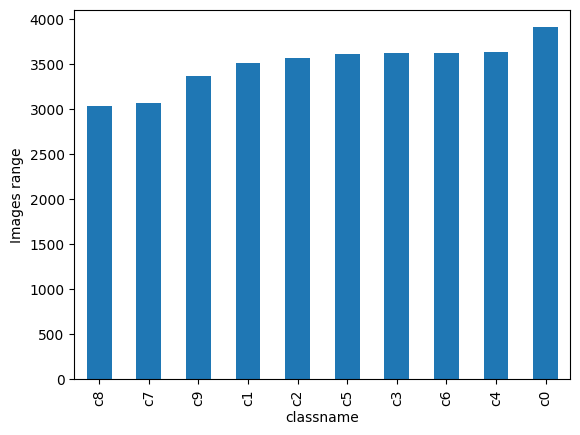

In [7]:
driver_imgs_list.groupby('classname')['img'].count().sort_values().plot(kind='bar')
plt.ylabel('Images range')
plt.show()

In [8]:
img = Image.open('C:/Users/lurpd/Documents/Development/Datasets/DistractedDriverSet/imgs/test/img_100015.jpg')
print(img.size)

(320, 240)


In [9]:
#add random letterboxing to trainng 
import numpy as np
from PIL import Image

def random_letterbox(img_array):
    #convert numpy array back to PIL for easier manipulation    
    if img_array.ndim == 3 and img_array.shape[-1] == 1:
        img_array = np.squeeze(img_array, axis=-1)

    img = Image.fromarray(np.uint8(img_array))
    target_size = (128, 128)
    
    #random scale factor 
    scale = np.random.uniform(0.8, 1.0)
    
    new_w = int(target_size[0] * scale)
    new_h = int(target_size[1] * scale)
    
    img = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
    
    #black background
    background = Image.new("L", target_size, 0)
    
    # Random offset on background
    x_offset = (target_size[0] - new_w) // 2
    y_offset = (target_size[1] - new_h) // 2
    
    background.paste(img, (x_offset, y_offset))
    
    #convert back to numpy float array
    arr = np.array(background).astype(np.float32)
    arr = np.expand_dims(arr, axis=-1)
    return arr / 255.0


In [10]:
image_size = (128,128)  # image shape
batch_size = 32
val_size = 0.2

train_data_gen = ImageDataGenerator(validation_split= val_size, preprocessing_function=random_letterbox, horizontal_flip=True)
test_data_gen = ImageDataGenerator(preprocessing_function=random_letterbox)

In [ ]:
# defining the training parameters


train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size = image_size,
                                                     batch_size = batch_size,
                                                     seed=42, 
                                                     shuffle=True,
                                                     subset='training',
                                                     color_mode='grayscale')

val_generator =  train_data_gen.flow_from_directory(train_dir,
                                               target_size = image_size,
                                               batch_size = batch_size,
                                               seed=42, 
                                               shuffle=True,
                                               subset='validation',
                                               color_mode='grayscale')



Found 17111 images belonging to 9 classes.
Found 4273 images belonging to 9 classes.
0 (c0): 5967
1 (c1): 1850
2 (c2): 2138
3 (c3): 1602
4 (c4): 1529
5 (c5): 1704
6 (c6): 1341
7 (c7): 628
8 (c8): 352


In [ ]:
import collections

class_counts = collections.Counter(train_generator.classes)
for cls, count in class_counts.items():
    print(f"{cls} ({list(train_generator.class_indices.keys())[cls]}): {count}")

(32, 128, 128, 1)
(32, 9)
(32, 128, 128, 1) 0.0 1.0


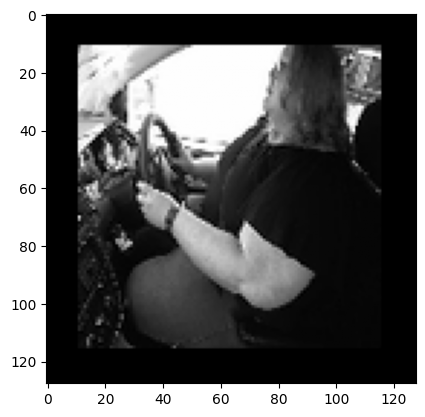

In [12]:
for data_batch,label_batch in train_generator:
    print(data_batch.shape)   # train batch
    print(label_batch.shape)  # label batch
    break

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_x.min(), batch_x.max())
plt.imshow(batch_x[0].squeeze(), cmap='gray')
plt.show()

In [13]:
model = Sequential()                                                  # creating a sequential model
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(128,128,1))) # taking units of 32 and filter of 3x3
model.add(MaxPooling2D(2,2))                                          # maxpool layer with 2x2 filter   
model.add(Conv2D(64,(3,3),activation='relu'))                         # taking units of 64 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))                        # taking units of 128 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu'))                        # taking units of 256 and filter of 3x3
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512,(3,3),activation='relu'))                        # taking units of 512 and filter of 3x3
model.add(MaxPooling2D(2,2))    
model.add(Flatten())                                                  # flattening the data to feed into to Dense layer
model.add(Dense(1024,activation='relu'))                              # taking units of 1024
model.add(Dense(512,activation='relu'))                               # taking units of 512 
model.add(Dense(128,activation='relu'))                               # taking units of 128
model.add(Dense(num_classes, activation='softmax'))                           # output later with units of 10 since 10 labels

model.summary() # to print summary of model architecture

c:\Users\lurpd\Documents\Development\DistractionAI\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,257,801 (16.24 MB)

 Trainable params: 4,257,801 (16.24 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
#give manual class weights since data is a bit weird with class proportions

class_weights = {
    0: 3.0,  #Safe driving (most important/likely)
    1: 1.0,  #Operating the radio
    2: 1.0,  #Drinking
    3: 0.8,  #Reaching behind
    4: 1.0,  #Hair and makeup
    5: 0.9,  #Talking to passenger
    6: 1.0,  #General Distracted
    7: 1.5,  #Sleepy, high risk
    8: 1.7   #Yawn, high risk
}

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 1/10


c:\Users\lurpd\Documents\Development\DistractionAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


535/535 ━━━━━━━━━━━━━━━━━━━━ 67s 124ms/step - accuracy: 0.4580 - loss: 1.3597 - val_accuracy: 0.6469 - val_loss: 1.5928
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.7669 - loss: 0.6223 - val_accuracy: 0.7271 - val_loss: 1.5325
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.8587 - loss: 0.3949 - val_accuracy: 0.7704 - val_loss: 1.3058
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.8974 - loss: 0.2953 - val_accuracy: 0.7545 - val_loss: 1.2847
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.9137 - loss: 0.2472 - val_accuracy: 0.7477 - val_loss: 1.3809
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.9256 - loss: 0.2175 - val_accuracy: 0.7653 - val_loss: 1.3194
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.9323 - loss: 0.1908 - val_accuracy: 0.7597 - val_loss: 1.3102
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.9396 - loss: 0.1773 - val_accura

In [16]:
model.save("distracted_driver_detection.keras")

In [17]:
tr_loss = history.history['loss']
tr_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

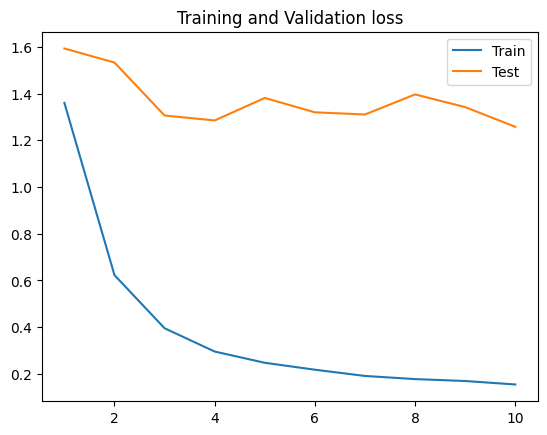

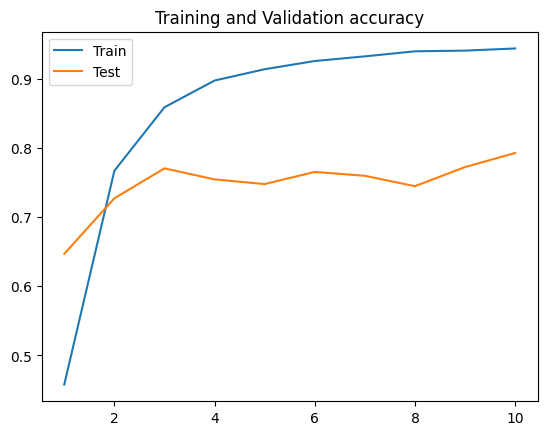

In [18]:
epchs = list(range(1,len(tr_loss)+1))
plt.plot(epchs,tr_loss,label='Train')
plt.plot(epchs,val_loss,label='Test')
plt.title("Training and Validation loss")
plt.legend()
plt.show()


plt.plot(epchs,tr_accuracy,label='Train')
plt.plot(epchs,val_accuracy,label='Test')
plt.title("Training and Validation accuracy")
plt.legend()
plt.show()

In [19]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

test_data = test_gen.flow_from_directory(
    images_dir,
    shuffle = False,
    target_size = image_size,
    classes = ['test'],
    batch_size = 32,
    color_mode='grayscale'
)

Found 84687 images belonging to 1 classes.


In [20]:
preds = model.predict(test_data)

2647/2647 ━━━━━━━━━━━━━━━━━━━━ 109s 41ms/step


In [21]:
# predictions on one batch of images

for data_batch,label_batch in test_data:
#     print(data_batch.shape,label_batch.shape)
    print(model.predict(data_batch).argmax(axis=1))
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[1 1 0 4 0 4 2 4 2 3 4 4 2 3 4 0 1 1 4 4 4 4 2 2 4 4 4 1 4 3 1 4]
